# Проект по количественной аналитике: разработка алгоритмических стратегий.

## IMPORTS

In [1]:
import random
import pandas as pd
import os
from datetime import timedelta
#pip install python-binance
from datetime import datetime
from binance.client import Client
import numpy as np 
from sklearn.model_selection import train_test_split
from utils.my_utils import * 
from utils.utils import * 
from utils.reductors import *
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
import math

from sklearn.preprocessing import MinMaxScaler, StandardScaler



## Часть 1: Модель машинного обучения на ежедневных данных.

### 1.1 Сбор данных.

Буду использовать апи от фьючей банана, потому что кажется для меня наиболее удобным и можно выгрузить хоть 50 лет по 1 минутке

In [2]:
client = Client("","") #создаем клиент от биржи, вместо апи-ключей пропуски, так как не будем работать с приватными данными

Для начала выгрузим список всех фьючерсов с банана в паре с датой начала их торгов

In [3]:
coins = [{"name" : coin['symbol'], "date": datetime.fromtimestamp(coin['onboardDate']/1000)} for coin in client.futures_exchange_info()['symbols'] if "USDT" in coin['symbol']]
print(len(coins))

306


получили список из 328 монет, предлагаю теперь еще немного сузить этот список, и взять 150 наиболее волотильных монет

Предлагаю взять 150 наиболее "СТАРЫХ" монет. Для чего я это делаю? Чтобы уменьшить шум и повысить качество своих будущих моделей, убрав новые монеты. Как по мне, поведение новых монет очень сложно предсказывать, так как в большинстве своем там очень много неопытных людей, покупающих монету, чтобы успеть в уходящий поезд с горами "прибыли" и продающие при первом же небольшом минусе. Поэтому возьмем 150 наиболее старых и будем верить, что нам это как-то поможет

In [4]:
coins.sort(key = lambda x: x['date']) # отсортили монеты старые -> новые
coins = coins[:150] # взяли 150 наиболее старых
print(f"the newest: {coins[-1]} \nthe oldest: {coins[0]}")

the newest: {'name': 'ASTRUSDT', 'date': datetime.datetime(2023, 2, 13, 10, 0)} 
the oldest: {'name': 'BTCUSDT', 'date': datetime.datetime(2019, 9, 25, 11, 0)}


теперь выгрузим сами данные:

In [5]:
preloaded = True #False если надо загрузить данные

START_DATE_STR = "2024-01-01 00:00:00" # возьмем за начало - начало текущего года

#добавим к начальной дате 180 дней
end_datetime = datetime.strptime(START_DATE_STR, "%Y-%m-%d %H:%M:%S") + timedelta(days=180)
END_DATE_STR = str(datetime.fromtimestamp(int(end_datetime.timestamp())))

print(f"Start date: {START_DATE_STR} \nEnd date: {END_DATE_STR}")


#создаем отдельную папку под все данные
data_dir = "coins_data/"
try:
    os.mkdir("coins_data")
except Exception as e:
    print(e)

coins_for_del = []
if not preloaded:
#обрабатываем и сохраняем все данные с биржи
    for i in tqdm(range(150)): 
        coin = coins[i]
        try:
            klines = client.futures_historical_klines(coin['name'], Client.KLINE_INTERVAL_1HOUR, start_str=START_DATE_STR,end_str=END_DATE_STR)
            date_ = []
            close_ = []
            for kln in klines:
                date_.append(datetime.fromtimestamp(kln[0] / 1000))
                close_.append(float(kln[4]))
            data = pd.DataFrame({'Date': date_,  'Close': close_})
            data.to_csv(data_dir + f"{coin['name']}.csv", index = False)
        except: 
            coins_for_del.append(coin)

for coin in coins_for_del:
    coins.remove(coin)

Start date: 2024-01-01 00:00:00 
End date: 2024-06-29 00:00:00
[Errno 17] File exists: 'coins_data'


### 1.2 2. Формирование окон: Разделить данные на окна длительностью 30 дней (720 точек) + разделение данных на train / test

Напишем функцию, которая на вход будет получать pandas dataframe c ценами 
закрытия инструмента, а на выходе выдавать другой датафрейм с 721 столбцом: 720 точек + таргет, который по ним надо предсказать 

In [6]:
def window_maker(coin):
    data = pd.read_csv(data_dir + f"{coin}.csv")  
    window_size = 721
    return np.lib.stride_tricks.sliding_window_view(data['Close'].values, window_size)
    

In [7]:
data = window_maker("BTCUSDT")

все суждения в дальнейшем будут производиться для одного инструмента для упрощения визуализции и рассуждений, в конце произведу прогонку по всем инструментам

### 1.3 Кластеризация окон.

для начала посмотрим вообще что там было

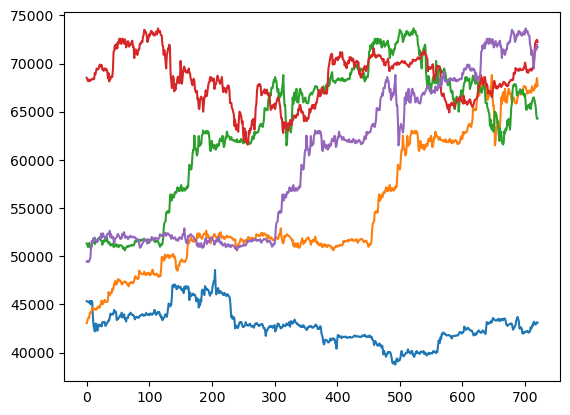

In [8]:
for i in range(5):
    plt.plot(random.choice(data))

первое, что бросается в глаза - разбой цен, так как в кластеризации нам важно скорее направление движения( подъем потом спуск, подъем спуск потом подъем и тд) то думаю стоит нормировать каждое окно

In [9]:
def normalize_windows(windows):
    normalized_arr = np.array([(sub_arr - np.min(sub_arr)) / (np.max(sub_arr) - np.min(sub_arr)) for sub_arr in windows])
    return normalized_arr



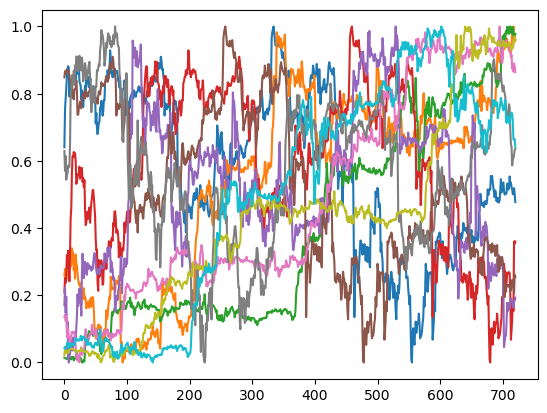

In [10]:
norm_data = normalize_windows(data)
for i in range(10):
    plt.plot(random.choice(norm_data))

теперь получили что-то +- одномерное и готовое к кластеризации

попробуем воспользоваться классическим методом K-means, если результат не устроит, то перейдем к чему-то более тяжелому, например TSNE

In [11]:
def plot_distortions(k_range, data):
    distortions = []
    K = k_range
    for k in tqdm(K):
        kmeanModel = KMeans(n_clusters=k,n_init = 'auto')
        kmeanModel.fit(data)
        distortions.append(kmeanModel.inertia_)

    plt.figure(figsize=(12,6))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('Elbow Method')
    plt.show()

100%|██████████| 9/9 [00:01<00:00,  4.86it/s]


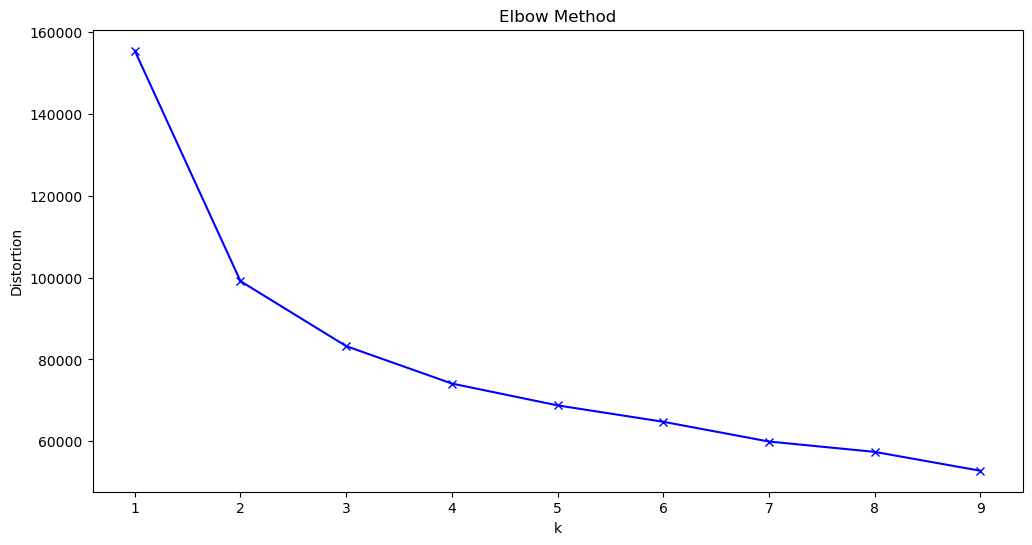

In [12]:
plot_distortions(range(1,10), norm_data)

видим, что это где-то в районе 4-6 кластеров

In [13]:
#рисовашка, которая рисует центроиды для всех классов начиная от 1 до заданного num_clusters
def plot_average_clusters(data, num_clusters):
    colors =['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple']
    fig, ax = plt.subplots(3, 3, figsize=(15, 10))
    ax = ax.reshape(-1)
    
    for clst_num in range(1, num_clusters+1):
        kmeanModel_tsfel = KMeans(n_clusters=clst_num,n_init = 'auto')
        kmeanModel_tsfel.fit(data)
        clusters = kmeanModel_tsfel.predict(data)
        for cluster in range(clst_num):
            averages = pd.DataFrame(data).groupby(clusters).mean().iloc[:, 128*0:128*(0+1)]
            ax[cluster].plot(averages.iloc[cluster].values, color=colors[clst_num-1],label=str(clst_num))
            ax[cluster].set_title(f"Cluster {cluster}, {sum(clusters==cluster)} observations")
            ax[cluster].legend(loc=1)
            ax[cluster].set_ylabel("Amplitude")
            ax[cluster].set_xlabel("observation")

    plt.tight_layout()
    plt.show()

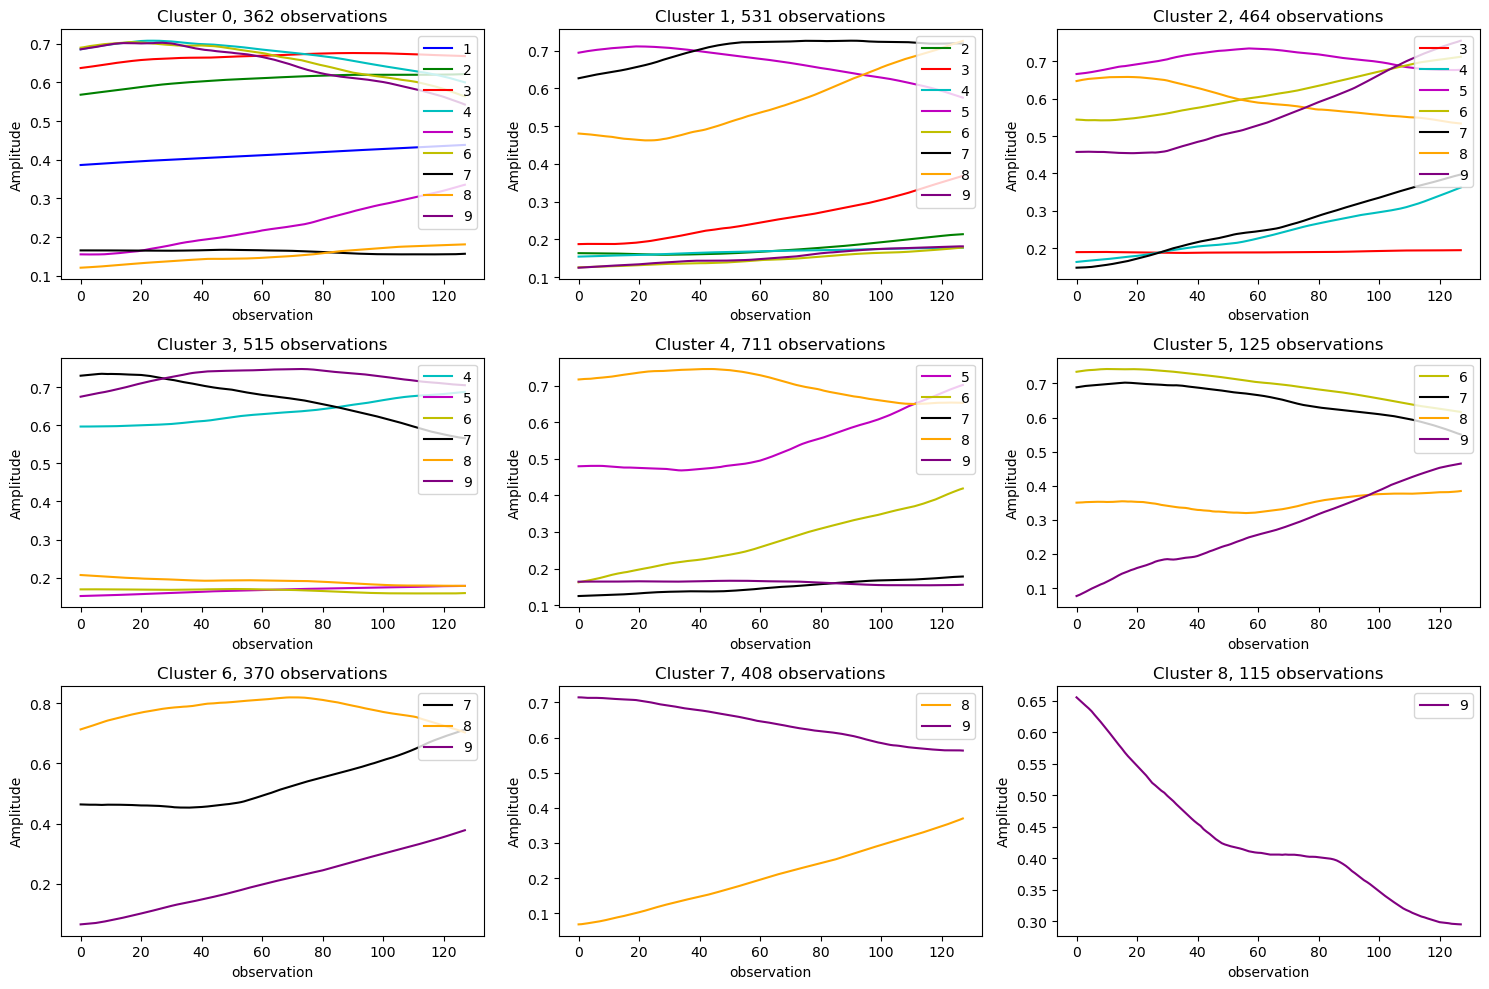

In [14]:
plot_average_clusters(norm_data, 9)

зрительно мне более приятно разделение на 9 кластеров

### 1.4 Cоздание признаков.

In [15]:
# макс значение каждого окна
def get_max(windows):
    return np.array(windows).max(axis = 1)

# мин значение каждого окна
def get_min(windows):
    return np.array(windows).min(axis = 1)

# среднее значение 
def get_mean(windows):
    return np.array(windows).mean(axis = 1)

# размах 
def get_range(windows):
    return get_max(windows) - get_min(windows)

# изменение за окно
def get_delta(windows):
    return windows[0] - windows[719]

def get_ma(windows, length):
     return windows.apply(lambda row: row.rolling(window=length).mean(), axis=1)

    

теперь создадим глобальный датафрейм на котором будем обучать нашу модель

In [16]:
df = pd.DataFrame(data) 
df.rename(columns = {720: 'target'}, inplace = True)

#получаем рабочие колонки для рядов (0-719) 
cols = df.columns.tolist()
cols.remove('target')

#считаем новые фичи
df['max'] = get_max(df[cols])
df['min'] = get_min(df[cols])
df['mean'] = get_mean(df[cols])
df['range'] = get_range(df[cols])
df['delta'] = get_delta(df[cols])
df['ma200'] = get_ma(df[cols], 200)[719]
df['ma60'] = get_ma(df[cols], 60)[719]
df['ma30'] = get_ma(df[cols], 30)[719]
df['ma15'] = get_ma(df[cols], 15)[719]


df

,0,1,2,3,4,5,6,7,8,9,...,target,max,min,mean,range,delta,ma200,ma60,ma30,ma15
0,42503.5,42647.9,42620.4,42369.8,42436.6,42272.6,42423.3,42527.0,42588.2,42688.8,...,42913.0,48577.9,38768.6,42928.621806,9809.3,-414.8,41226.6045,42767.415000,43332.463333,43386.433333
1,42647.9,42620.4,42369.8,42436.6,42272.6,42423.3,42527.0,42588.2,42688.8,42727.7,...,42770.9,48577.9,38768.6,42929.190556,9809.3,-265.1,41238.5490,42775.913333,43329.163333,43359.826667
2,42620.4,42369.8,42436.6,42272.6,42423.3,42527.0,42588.2,42688.8,42727.7,42727.6,...,42865.6,48577.9,38768.6,42929.361389,9809.3,-150.5,41248.8295,42782.331667,43321.970000,43313.613333
3,42369.8,42436.6,42272.6,42423.3,42527.0,42588.2,42688.8,42727.7,42727.6,42682.0,...,42918.0,48577.9,38768.6,42929.701944,9809.3,-495.8,41261.5540,42792.236667,43313.230000,43270.426667
4,42436.6,42272.6,42423.3,42527.0,42588.2,42688.8,42727.7,42727.6,42682.0,42753.9,...,42951.5,48577.9,38768.6,42930.463333,9809.3,-481.4,41277.0815,42803.461667,43305.216667,43239.413333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,67516.3,67737.0,67720.6,67686.7,67619.1,67842.6,67980.0,68156.0,68214.3,68180.0,...,60248.1,71750.0,59294.7,66545.854306,12455.3,7384.1,62603.3815,61307.848333,61441.623333,61198.360000
3597,67737.0,67720.6,67686.7,67619.1,67842.6,67980.0,68156.0,68214.3,68180.0,67879.2,...,60365.4,71750.0,59294.7,66535.759583,12455.3,7488.9,62574.8225,61287.676667,61392.566667,61109.693333
3598,67720.6,67686.7,67619.1,67842.6,67980.0,68156.0,68214.3,68180.0,67879.2,67627.8,...,60378.1,71750.0,59294.7,66525.521250,12455.3,7355.2,62551.0555,61271.011667,61352.396667,61027.033333
3599,67686.7,67619.1,67842.6,67980.0,68156.0,68214.3,68180.0,67879.2,67627.8,67723.3,...,60429.8,71750.0,59294.7,66515.323333,12455.3,7308.6,62528.2795,61256.403333,61308.296667,60964.380000


### 1.5 Разметка данных

Предлагается изучить волотильность и в зависимости от нее взять целевые метки классов, которые будем предсказывать. Давайте так и поступим. Буду делать так: найду попарную абсолютную(по модулю) процентную разницу между всеми двумя соседними часами, а потом возьму среднее и буду считать, что если цена изменилась на процент, меньший данного - это боковик (целевая метка 0), больше + увеличилаь - рост (метка 1), больше и уменьшилась - падение (метка 2)  

In [17]:
# Функция для вычисления средней процентной разницы по модулю для каждой строки
def average_percentage_difference(row):
    # Вычисляем процентную разницу между соседними столбцами
    percentage_diff = row.pct_change().abs() * 100
    # Игнорируем первое значение NaN, возникшее в результате pct_change()
    return percentage_diff[1:].mean()


# Применяем функцию ко всем строкам датафрейма
df['avg_pct_diff'] = df[cols].apply(average_percentage_difference, axis=1)

def calculate_label(row):
    # Процентное изменение между столбцами 'target' и '719'
    pct_change_target_719 = ((row[719] - row['target']) / row['target']) * 100
    # Сравниваем процентное изменение с ранее посчитанным средним
    if pct_change_target_719 > row['avg_pct_diff']:
        return 1  # Цена увеличилась на больший процент, чем среднее
    elif pct_change_target_719 < -row['avg_pct_diff']:
        return 2  # Цена уменьшилась на больший процент, чем среднее
    else:
        return 0  # Цена осталась в пределах среднего


df['target'] = df.apply(calculate_label, axis=1)


#после подсчета таргета - нормализуем таргет для нормального обучения модели
normalized_df = pd.DataFrame(normalize_windows(data))
df[cols] = normalized_df[cols]

# на нормализованных данных кластеризуем окна
kmeanModel_tsfel = KMeans(n_clusters=9,n_init = 'auto')
kmeanModel_tsfel.fit(df[cols])
clusters = kmeanModel_tsfel.predict(df[cols])
df = pd.concat([df,pd.DataFrame({"cluster9": clusters})], axis = 1)


In [18]:

df

,0,1,2,3,4,5,6,7,8,9,...,min,mean,range,delta,ma200,ma60,ma30,ma15,avg_pct_diff,cluster9
0,0.380751,0.395472,0.392668,0.367121,0.373931,0.357212,0.372575,0.383147,0.389386,0.399641,...,38768.6,42928.621806,9809.3,-414.8,41226.6045,42767.415000,43332.463333,43386.433333,0.376160,3
1,0.395472,0.392668,0.367121,0.373931,0.357212,0.372575,0.383147,0.389386,0.399641,0.403607,...,38768.6,42929.190556,9809.3,-265.1,41238.5490,42775.913333,43329.163333,43359.826667,0.375705,3
2,0.392668,0.367121,0.373931,0.357212,0.372575,0.383147,0.389386,0.399641,0.403607,0.403597,...,38768.6,42929.361389,9809.3,-150.5,41248.8295,42782.331667,43321.970000,43313.613333,0.376076,3
3,0.367121,0.373931,0.357212,0.372575,0.383147,0.389386,0.399641,0.403607,0.403597,0.398948,...,38768.6,42929.701944,9809.3,-495.8,41261.5540,42792.236667,43313.230000,43270.426667,0.375566,3
4,0.373931,0.357212,0.372575,0.383147,0.389386,0.399641,0.403607,0.403597,0.398948,0.406278,...,38768.6,42930.463333,9809.3,-481.4,41277.0815,42803.461667,43305.216667,43239.413333,0.375516,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,0.660088,0.677808,0.676491,0.673769,0.668342,0.686286,0.697318,0.711448,0.716129,0.713375,...,59294.7,66545.854306,12455.3,7384.1,62603.3815,61307.848333,61441.623333,61198.360000,0.249061,1
3597,0.677808,0.676491,0.673769,0.668342,0.686286,0.697318,0.711448,0.716129,0.713375,0.689225,...,59294.7,66535.759583,12455.3,7488.9,62574.8225,61287.676667,61392.566667,61109.693333,0.248875,1
3598,0.676491,0.673769,0.668342,0.686286,0.697318,0.711448,0.716129,0.713375,0.689225,0.669040,...,59294.7,66525.521250,12455.3,7355.2,62551.0555,61271.011667,61352.396667,61027.033333,0.249112,1
3599,0.673769,0.668342,0.686286,0.697318,0.711448,0.716129,0.713375,0.689225,0.669040,0.676708,...,59294.7,66515.323333,12455.3,7308.6,62528.2795,61256.403333,61308.296667,60964.380000,0.249072,1


In [19]:
values = dict(df['target'].value_counts())
print(values)
print(f"доля нулей: {values[0]/ (values[0] + values[1] + values[2])}")

{0: 2426, 2: 613, 1: 562}
доля нулей: 0.6737017495140238


### 1.6 Обучение модели.

в качестве модели предлагаю использовать lgbm многоклассовый клаcсификатор. А в качестве метрики - всеми любимый для задач классификации roc_auc_score

In [20]:
feature_cols = df.columns.tolist()
feature_cols.remove('target')
X_train, X_test, y_train, y_test = train_test_split(df[feature_cols], df['target'], test_size=0.33, random_state=42, shuffle = False)


In [21]:

params = {
    "boosting_type": "gbdt ",
    "objective": "multiclass",
    "num_class": 3,
    "max_depth": 50,  
    "learning_rate": 0.001,
    "n_estimators": 1000,  
    "colsample_bytree": 0.8,
    "colsample_bynode": 0.9,
    "verbose": -1,
    "random_state": 42,
    #"reg_alpha": 0.1,
    #"reg_lambda": 10,
    "extra_trees":True,
    'num_leaves': 64,
    'n_threads' : -1,
}



lgb_tr = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_test, label=y_test, reference=lgb_tr)

model = lgb.train(params, lgb_tr, valid_sets=[lgb_val],num_boost_round=500, callbacks=[lgb.log_evaluation(100)])


/opt/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	valid_0's multi_logloss: 0.787355
[200]	valid_0's multi_logloss: 0.785895
[300]	valid_0's multi_logloss: 0.78488
[400]	valid_0's multi_logloss: 0.783724
[500]	valid_0's multi_logloss: 0.782602
[600]	valid_0's multi_logloss: 0.781712
[700]	valid_0's multi_logloss: 0.781045
[800]	valid_0's multi_logloss: 0.78062
[900]	valid_0's multi_logloss: 0.779957
[1000]	valid_0's multi_logloss: 0.779365


### 1.7 Оценка модели

Введем более понятную функцию скора - процент правильно угаданных дней

In [22]:
def my_score(pred, true_vals):
    true_count = sum(guessed == original for guessed, original in zip(pred, true_vals))
    return true_count/len(pred)*100

y_pred = model.predict(X_test).argmax(axis = 1)
my_score(y_pred, y_test)

72.83431455004205

и еще попробуем обычный rf classifier

In [23]:
model = RandomForestClassifier()
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
my_score(y_pred, y_test)

71.48864592094198

### Pipeline

теперь составим пайплайн, который будем применять к монетам

In [34]:
import warnings 
warnings.filterwarnings('ignore')

def pipeline(coin):
    data = window_maker(coin)
    
    df = pd.DataFrame(data) 
    df.rename(columns = {720: 'target'}, inplace = True)
    
    #получаем рабочие колонки для рядов (0-719) 
    cols = df.columns.tolist()
    cols.remove('target')
    
    #считаем новые фичи
    df['max'] = get_max(df[cols])
    df['min'] = get_min(df[cols])
    df['mean'] = get_mean(df[cols])
    df['range'] = get_range(df[cols])
    df['delta'] = get_delta(df[cols])
    df['ma200'] = get_ma(df[cols], 200)[719]
    df['ma60'] = get_ma(df[cols], 60)[719]
    df['ma30'] = get_ma(df[cols], 30)[719]
    df['ma15'] = get_ma(df[cols], 15)[719]

    

    
    df['avg_pct_diff'] = df[cols].apply(average_percentage_difference, axis=1)
    df['target'] = df.apply(calculate_label, axis=1) 

    #после подсчета таргета - нормализуем таргет для нормального обучения модели
    normalized_df = pd.DataFrame(normalize_windows(data))
    df[cols] = normalized_df[cols]
    df.fillna(0, inplace = True)
    
    # на нормализованных данных кластеризуем окна
    kmeanModel_tsfel = KMeans(n_clusters=9,n_init = 'auto')
    kmeanModel_tsfel.fit(df[cols])
    clusters = kmeanModel_tsfel.predict(df[cols])
    df = pd.concat([df,pd.DataFrame({"cluster9": clusters})], axis = 1)
    #display(df)
    df.fillna(0,inplace = True)

    
    values = dict(df['target'].value_counts())
    nuls_val = values[0]/ (values[0] + values[1] + values[2])

    feature_cols = df.columns.tolist()
    feature_cols.remove('target')
    X_train, X_test, y_train, y_test = train_test_split(df[feature_cols], df['target'], test_size=0.33, random_state=42, shuffle = False)

    
    params = {
        "boosting_type": "rf",
        "objective": "multiclass",
        "num_class": 3,
        "max_depth": 50,  
        "learning_rate": 0.003,
        "n_estimators": 500,  
        "colsample_bytree": 0.7,
        "colsample_bynode": 0.7,
        "verbose": -1,
        "random_state": 42,
        #"reg_alpha": 0.1,
        #"reg_lambda": 10,
        "extra_trees":True,
        'num_leaves': 64,
        'n_threads' : -1,
    }
    
    
    
    lgb_tr = lgb.Dataset(X_train, label=y_train)
    lgb_val = lgb.Dataset(X_test, label=y_test, reference=lgb_tr)
    
    model = lgb.train(params, lgb_tr, valid_sets=[lgb_val],num_boost_round=500)

    y_pred = model.predict(X_test).argmax(axis = 1)
    lgbm_score = my_score(y_pred, y_test)

    model = RandomForestClassifier()
    X_train.columns = X_train.columns.astype(str)
    X_test.columns = X_test.columns.astype(str)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rf_score = my_score(y_pred, y_test)

    return nuls_val, lgbm_score, rf_score

In [35]:
res = []
for coin in tqdm(coins):
    try:
        res.append([coin['name']] + list(pipeline(coin['name'])))
    except Exception as e:
        print(e)

 44%|████▍     | 66/150 [20:54<19:37, 14.02s/it]

1


 55%|█████▌    | 83/150 [26:02<20:38, 18.48s/it]

[Errno 2] No such file or directory: 'coins_data/BTCSTUSDT.csv'


 67%|██████▋   | 100/150 [30:41<11:13, 13.48s/it]

1


 72%|███████▏  | 108/150 [32:51<09:27, 13.50s/it]

1


 87%|████████▋ | 130/150 [39:27<04:45, 14.27s/it]

1


100%|██████████| 150/150 [45:41<00:00, 18.28s/it]


In [36]:
res = pd.DataFrame(res, columns = ['coin', 'zeros', 'lgbm score', 'rf score'])
res.to_csv("res.csv")
res

,coin,zeros,lgbm score,rf score
0,BTCUSDT,0.673702,72.834315,72.750210
1,ETHUSDT,0.661761,69.638352,54.415475
2,BCHUSDT,0.659539,67.451640,65.012616
3,XRPUSDT,0.660372,68.881413,68.881413
4,EOSUSDT,0.642599,65.180824,62.825904
...,...,...,...,...
140,MAGICUSDT,0.656207,64.423886,63.919260
141,TUSDT,0.663427,68.713204,60.302775
142,HIGHUSDT,0.635101,67.872161,55.677040
143,MINAUSDT,0.660928,66.778806,64.507990


In [49]:
res[(res['rf score']/100 > res['zeros']) | (res['lgbm score']/100 > res['zeros'])]

,coin,zeros,lgbm score,rf score
0,BTCUSDT,0.673702,72.834315,72.750210
1,ETHUSDT,0.661761,69.638352,54.415475
2,BCHUSDT,0.659539,67.451640,65.012616
3,XRPUSDT,0.660372,68.881413,68.881413
4,EOSUSDT,0.642599,65.180824,62.825904
...,...,...,...,...
137,FETUSDT,0.622049,62.405383,60.891505
139,HOOKUSDT,0.646487,57.695542,66.274180
141,TUSDT,0.663427,68.713204,60.302775
142,HIGHUSDT,0.635101,67.872161,55.677040


специально для каких-то рассуждения добавил стобец zeros - процент нулей (боковиков). То есть этот скор мы бы получали, если бы просто считали, что у нас всегда боковик. Этот скор будет нашим бейзланом, как мы видим, мы смогли побить его для 92 монет, в целом считаю это неплохим результатом

## Часть 2: Модель машинного обучения на высокочастотных данных

In [28]:
trades = pd.read_csv("trades.csv")
trades.drop(columns = ["Unnamed: 0"], inplace=True) #удаляем колонку старых ненужных индексов

lob = pd.read_csv("lob.csv")
lob.drop(columns = ["Unnamed: 0"], inplace=True) #удаляем колонку старых ненужных индексов


In [29]:
display(trades.head(5))
display(lob.head(5))

,local_timestamp,side,price,amount
0,1722470400014926,sell,0.011043,734
1,1722470402982045,sell,0.011043,1633
2,1722470402982047,sell,0.011043,25445
3,1722470402996765,sell,0.011043,4471
4,1722470403047136,buy,0.011044,5378


,local_timestamp,asks[0].price,asks[0].amount,bids[0].price,bids[0].amount,asks[1].price,asks[1].amount,bids[1].price,bids[1].amount,asks[2].price,...,bids[22].price,bids[22].amount,asks[23].price,asks[23].amount,bids[23].price,bids[23].amount,asks[24].price,asks[24].amount,bids[24].price,bids[24].amount
0,1722470402038431,0.011044,121492.0,0.011043,103687.0,0.011044,4663.0,0.011043,36226.0,0.011044,...,0.011040,147374.0,0.011047,666690.0,0.011040,69663.0,0.011047,1000463.0,0.011040,90028.0
1,1722470402305331,0.011044,121492.0,0.011043,100499.0,0.011044,4663.0,0.011043,36226.0,0.011044,...,0.011040,147374.0,0.011047,666690.0,0.011040,69663.0,0.011047,1000463.0,0.011040,90028.0
2,1722470403485121,0.011041,60925.0,0.011041,747323.0,0.011041,59430.0,0.011040,337839.0,0.011042,...,0.011038,27842.0,0.011045,173025.0,0.011038,77932.0,0.011045,162045.0,0.011038,2520.0
3,1722470403950214,0.011042,47154.0,0.011042,659456.0,0.011042,721458.0,0.011041,168126.0,0.011042,...,0.011039,6299.0,0.011046,1495.0,0.011039,109781.0,0.011046,4619.0,0.011038,132214.0
4,1722470404424495,0.011042,463599.0,0.011042,34546.0,0.011042,4619.0,0.011041,102775.0,0.011042,...,0.011038,1495.0,0.011045,30170.0,0.011038,61706.0,0.011045,638314.0,0.011038,27842.0


### 2.1 Подумать, что может являться таргетом в этой задаче. Сгенерировать таргет

Прочитав предложенную статью и прочитав несколько других, понял, что можно предсказывать следующие вещи:
- mid price - средняя цена между спросом и предложением, по которой ордрера будут в среднем исполняться
- мета ордера - очень крупные ордера принадлежащие крупным игрокам, на таких больших объемаъ как правило бывают хорошие движения цены, которые можно попробовтаь забирать

Но так как нам выдали ресерч с фичами для mid price, то буду считать это намеком на то, что предсказывать надо именно ее! mid_price = (ask + bid) / 2. Посчитаем ее ниже + отобразим спрос и предложение глубины 3


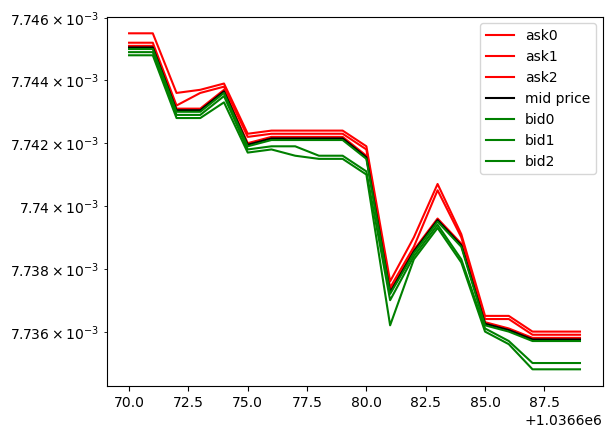

In [30]:
length = 20
lob['mid_price'] = (lob['asks[0].price'] + lob['bids[0].price']) / 2 
plt.plot(lob['asks[0].price'][-length:],label = 'ask0', color = 'red')
plt.plot(lob['asks[1].price'][-length:],label = 'ask1', color = 'red')
plt.plot(lob['asks[2].price'][-length:],label = 'ask2', color = 'red')
plt.plot(lob.mid_price[-length:], label = 'mid price', color = 'black')
plt.plot(lob['bids[0].price'][-length:],label = 'bid0', color = 'green')
plt.plot(lob['bids[1].price'][-length:],label = 'bid1', color = 'green')
plt.plot(lob['bids[2].price'][-length:],label = 'bid2', color = 'green')
plt.legend()
plt.yscale('log')

### 2.2 Выбор типа задачи (регрессия/классификация) + метрики для нее

в данном случае имеем задачу регрессии. Думаю разумнее всего использоватб какие-то обычнные метрики на евклидовом расстоянии семейства MSE. В частности предлагаю сипользвовать квадратичный MSE - RMSE, чтобы серьезнее штрафовать.

Более того, нам нужно выбрать два параметра - T, t.
- T - сколько тиков назад мы можем смотреть для обучения регрессии
- t - на сколько тиков вперед мы хотим предсказывать

Предлагаю сделать простенький бейзлайн, который в дальнейшем будем бить:  возьмем предыдущие несколько тиков и предскажем будущий без генерации доп фичей фичей + посмотрим на скор

In [31]:
def RMSE(pred, target):
    MSE = np.square(np.subtract(target,pred)).mean() 
    return math.sqrt(MSE)

In [32]:
T = 50
t = 10 # попробуем угадать цену на 10 тиков вперед 

In [33]:
def window_maker(data, window_size):
    return np.lib.stride_tricks.sliding_window_view(data['mid_price'].values, window_size)

def normalize_row_minmax(row):
    scaler = MinMaxScaler()
    return scaler.fit_transform(row.values.reshape(-1,1)).flatten()

def normalize_row(row): 
    scaler = StandardScaler()
    return scaler.fit_transform(row.values.reshape(-1,1)).flatten()
    
# делаем окна + таргет (смещая mid_price на t)
df = pd.DataFrame(window_maker(lob, T))
df['target'] = lob['mid_price'].shift(-t-T)
df = df.rename(str,axis="columns") 
df = df[:-t-1]

# проводим min_max scale чтобы далее работать с временным рядом, без этого будет плохой скор
df = df.apply(normalize_row, axis = 1, result_type = 'expand')
df.rename(columns = {50:"target"},inplace= True)
df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,target
0,1.670095,1.670095,1.290123,1.452968,1.452968,1.113707,1.303693,1.615813,1.670095,0.991573,...,0.068783,0.550534,1.290123,1.154418,1.235841,0.801587,0.380904,0.380904,-0.419752,0.788017
1,1.724375,1.336380,1.502664,1.502664,1.156240,1.350237,1.668947,1.724375,1.031527,0.574248,...,0.581177,1.336380,1.197811,1.280952,0.837530,0.407965,0.407965,-0.409595,0.463393,1.114669
2,1.372627,1.541872,1.541872,1.189278,1.386731,1.711117,1.767532,1.062344,0.596921,0.596921,...,1.372627,1.231589,1.316212,0.864892,0.427675,0.427675,-0.404446,0.484091,1.132863,1.146967
3,1.555780,1.555780,1.201087,1.399715,1.726033,1.782784,1.073398,0.605203,0.605203,0.605203,...,1.243650,1.328777,0.874770,0.434951,0.434951,-0.402124,0.491702,1.144336,1.144336,1.158524
4,1.607474,1.245142,1.448048,1.781393,1.839366,1.114703,0.636425,0.636425,0.636425,0.158147,...,1.375581,0.911797,0.462506,0.462506,-0.392597,0.520479,1.187169,1.187169,1.042236,0.839331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036625,-0.073792,0.539505,0.483750,-0.575581,-0.575581,-1.356141,-1.244633,-1.188878,1.766099,1.236433,...,0.204979,0.316488,1.877608,1.821853,1.821853,1.821853,0.706768,0.706768,1.041293,-3.084524
1036626,0.534736,0.479362,-0.572737,-0.572737,-1.347968,-1.237221,-1.181847,1.752956,1.226906,0.866978,...,0.313241,1.863703,1.808330,1.808330,1.808330,0.700857,0.700857,1.033099,0.091747,-3.175299
1036627,0.485189,-0.558425,-0.558425,-1.327403,-1.217549,-1.162622,1.748510,1.226704,0.869678,0.485189,...,1.858364,1.803437,1.803437,1.803437,0.704897,0.704897,1.034459,0.100700,0.210554,-3.304776
1036628,-0.554087,-0.554087,-1.324521,-1.214459,-1.159428,1.757216,1.234421,0.876719,0.491502,1.427030,...,1.812247,1.812247,1.812247,0.711626,0.711626,1.041813,0.106285,0.216347,0.216347,-3.305637


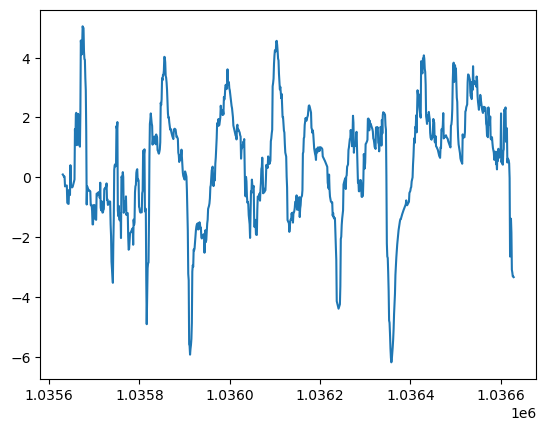

In [34]:
plt.plot(df['target'][-1000:])

In [35]:
# делим данные на обучение + тест и обучаем пробную модель 
train_df = df[:-10000]
test_df = df[-10000:]

feature_cols = df.columns.to_list()
feature_cols.remove('target')

params = {
        "boosting_type": "gbdt",
        "metrics" : "rmse",
        "objective": "regression",
        "max_depth": 50, 
        "learning_rate": 0.15,
        "n_estimators": 3500,  
        "colsample_bytree": 0.7,
        "colsample_bynode": 0.7,
        "verbose": -1,
        "random_state": 42,
        "extra_trees":True,
        'num_leaves': 30,
        'n_threads' : -1,
    }
    
    
lgb_tr = lgb.Dataset(train_df[feature_cols], label=train_df['target'])
lgb_val = lgb.Dataset(test_df[feature_cols], label=test_df['target'], reference=lgb_tr)
    
model = lgb.train(params, lgb_tr, valid_sets=[lgb_val],num_boost_round=200, callbacks=[lgb.log_evaluation(100)])
y_pred = model.predict(test_df[feature_cols])

y_pred = model.predict(test_df[feature_cols])
print(y_pred)
print(f"Model score: {RMSE(test_df['target'], y_pred)}")

[100]	valid_0's rmse: 1.21691
[200]	valid_0's rmse: 1.07597
[300]	valid_0's rmse: 0.980863
[400]	valid_0's rmse: 0.909324
[500]	valid_0's rmse: 0.848351
[600]	valid_0's rmse: 0.796063
[700]	valid_0's rmse: 0.75376
[800]	valid_0's rmse: 0.717226
[900]	valid_0's rmse: 0.684935
[1000]	valid_0's rmse: 0.657426
[1100]	valid_0's rmse: 0.632566
[1200]	valid_0's rmse: 0.610182
[1300]	valid_0's rmse: 0.591008
[1400]	valid_0's rmse: 0.573747
[1500]	valid_0's rmse: 0.557767
[1600]	valid_0's rmse: 0.543464
[1700]	valid_0's rmse: 0.53074
[1800]	valid_0's rmse: 0.519254
[1900]	valid_0's rmse: 0.508767
[2000]	valid_0's rmse: 0.499579
[2100]	valid_0's rmse: 0.490627
[2200]	valid_0's rmse: 0.483472
[2300]	valid_0's rmse: 0.476045
[2400]	valid_0's rmse: 0.469657
[2500]	valid_0's rmse: 0.463213
[2600]	valid_0's rmse: 0.457869
[2700]	valid_0's rmse: 0.452995
[2800]	valid_0's rmse: 0.448177
[2900]	valid_0's rmse: 0.443837
[3000]	valid_0's rmse: 0.439958
[3100]	valid_0's rmse: 0.436481
[3200]	valid_0's rmse

Посмотрим визуально на предсказанные моделью данные

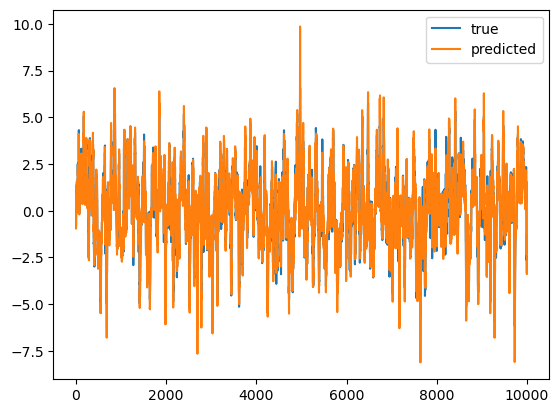

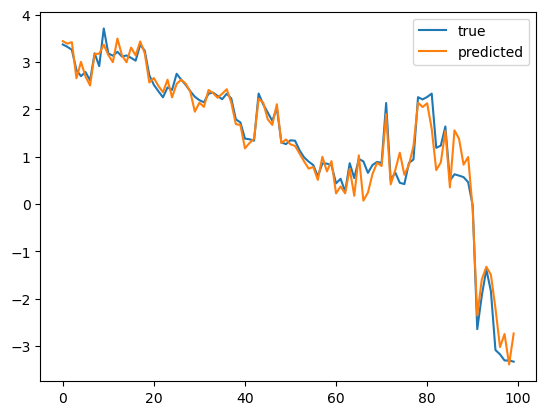

In [36]:
y_pred = model.predict(test_df[feature_cols])
plt.plot(test_df['target'].to_list(),label = 'true')
plt.plot(y_pred, label = 'predicted')
plt.legend()
plt.show()

plt.plot(test_df['target'].to_list()[-100:],label = 'true')
plt.plot(y_pred[-100:], label = 'predicted')
plt.legend()
plt.show()

в целом получили какой-никакой бейзлан, попробуем теперь его улучшить за счет генерации фич

### 2.3 Генерация фичей

In [37]:
lob_depth = 25

features_df = pd.DataFrame()
for i in range(lob_depth):
    #группа фич 1 - спред (разница между ценой спроса и предложения), арбитраж 2014 привет
    features_df[f'spread{i}'] = lob[f'asks[{i}].price'] - lob[f'bids[{i}].price']


    #группа фич 2 - price difference - абсолютная разница между ценами спроса и предложения на каждом уровне
    if i >= 1:
        features_df[f'price_difference_asks{i}'] = abs(lob[f'asks[{i}].price'] - lob[f'asks[{i-1}].price'])
        features_df[f'price_difference_bids{i}'] = abs(lob[f'bids[{i}].price'] - lob[f'bids[{i-1}].price'])


#группа фич 2.1 - price difference между крайними уровнями
features_df['price_difference_asks'] = lob[f'asks[{lob_depth - 1}].price'] - lob['asks[0].price']
features_df['price_difference_bids'] = lob[f'bids[{lob_depth - 1}].price'] - lob['bids[0].price']


#группа фич 3 - средняя значение по всем уровням 
bids_columns_price = [f'bids[{i}].price' for i in range(lob_depth)]
asks_columns_price = [f'asks[{i}].price' for i in range(lob_depth)]

bids_columns_amount = [f'bids[{i}].amount' for i in range(lob_depth)]
asks_columns_amount = [f'asks[{i}].amount' for i in range(lob_depth)]

features_df['bids_mean_price'] = lob[bids_columns_price].mean(axis = 1)
features_df['asks_mean_price'] = lob[asks_columns_price].mean(axis = 1)

features_df['bids_mean_amount'] = lob[bids_columns_amount].mean(axis = 1)
features_df['asks_mean_amount'] = lob[asks_columns_amount].mean(axis = 1)


#фича 4 - Accumulated Differences - разница между суммой bids и asks 
features_df['acc_dif_price'] = lob[asks_columns_price].sum(axis = 1) - lob[bids_columns_price].sum(axis = 1)
features_df['acc_dif_amount'] = lob[asks_columns_amount].sum(axis = 1) - lob[bids_columns_amount].sum(axis = 1)

df[features_df.columns.to_list()] = features_df
df

#фича 5 - максимум цены за окно
df['high'] = df[[i for i in range(T)]].max(axis = 1) 

#фича 6 - минимум цены за окно 
df['min'] = df[[i for i in range(T)]].min(axis = 1)

#фича 7 - средняя цена за окно
df['mean'] = df[[i for i in range(T)]].mean(axis = 1)

# далее идут фичи построенные на технических индикаторах


# rsi - Индекс относительной силы (RSI от англ. relative strength index)
def rsi(row, n=14):
    return 100 - (100 / (
            1 + row.diff(1).mask(row.diff(1) < 0, 0).ewm(alpha=1 / n, adjust=False).mean() / row.diff(1).mask(
        row.diff(1) > 0, -0.0).abs().ewm(alpha=1 / n, adjust=False).mean()))[-1]



#WMA - средневзвешенное за период, нужно для подсчета HMA 
def WMA(row, period):
    return row.rolling(period).apply(lambda x: ((np.arange(period) + 1) * x).sum() / (np.arange(period) + 1).sum(),
                                   raw=True)

#HMA - Hull Moving Average - один из вариантов сколячей средней
def HMA(row, period):
    res = WMA(WMA(row, period // 2).multiply(2).sub(WMA(row, period)), int(np.sqrt(period)))
    return res[-1]

#MA - Moving Average - самая стандартная скользящая средняя 
def MA(row, period):
    return row[-period:].mean()

#фича 8
df['ma10'] = df[[i for i in range(T)]].apply((lambda x: MA(x, 10)), axis = 1, result_type = 'expand')
df['ma15'] = df[[i for i in range(T)]].apply((lambda x: MA(x, 15)), axis = 1, result_type = 'expand')
df['ma20'] = df[[i for i in range(T)]].apply((lambda x: MA(x, 20)), axis = 1, result_type = 'expand')


#далее для rsi и hma нужны ненормализованные данные
# делаем снова окна и считаем на них новые индикаторы
tmp_df = pd.DataFrame(window_maker(lob, T))
tmp_df = tmp_df.rename(str,axis="columns") 
tmp_df = tmp_df[:-t-1]
display(tmp_df)
# #фича 9
df['hma10'] = tmp_df.apply((lambda x: HMA(x, 10)), axis = 1, result_type = 'expand')
df['hma20'] = tmp_df.apply((lambda x: HMA(x, 20)), axis = 1, result_type = 'expand')
df['hma30'] = tmp_df.apply((lambda x: HMA(x, 30)), axis = 1, result_type = 'expand')
#фича 10
df['rsi14'] = tmp_df.apply((lambda x: rsi(x, 14)), axis = 1, result_type = 'expand')



,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.011044,0.011044,0.011041,0.011042,0.011042,0.011039,0.011041,0.011043,0.011044,0.011039,...,0.011030,0.011032,0.011035,0.011041,0.011040,0.011040,0.011037,0.011034,0.011034,0.011028
1,0.011044,0.011041,0.011042,0.011042,0.011039,0.011041,0.011043,0.011044,0.011039,0.011035,...,0.011032,0.011035,0.011041,0.011040,0.011040,0.011037,0.011034,0.011034,0.011028,0.011034
2,0.011041,0.011042,0.011042,0.011039,0.011041,0.011043,0.011044,0.011039,0.011035,0.011035,...,0.011035,0.011041,0.011040,0.011040,0.011037,0.011034,0.011034,0.011028,0.011034,0.011039
3,0.011042,0.011042,0.011039,0.011041,0.011043,0.011044,0.011039,0.011035,0.011035,0.011035,...,0.011041,0.011040,0.011040,0.011037,0.011034,0.011034,0.011028,0.011034,0.011039,0.011039
4,0.011042,0.011039,0.011041,0.011043,0.011044,0.011039,0.011035,0.011035,0.011035,0.011032,...,0.011040,0.011040,0.011037,0.011034,0.011034,0.011028,0.011034,0.011039,0.011039,0.011038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036625,0.007742,0.007743,0.007743,0.007741,0.007741,0.007739,0.007740,0.007740,0.007745,0.007744,...,0.007741,0.007742,0.007742,0.007745,0.007745,0.007745,0.007745,0.007743,0.007743,0.007744
1036626,0.007743,0.007743,0.007741,0.007741,0.007739,0.007740,0.007740,0.007745,0.007744,0.007743,...,0.007742,0.007742,0.007745,0.007745,0.007745,0.007745,0.007743,0.007743,0.007744,0.007742
1036627,0.007743,0.007741,0.007741,0.007739,0.007740,0.007740,0.007745,0.007744,0.007743,0.007743,...,0.007742,0.007745,0.007745,0.007745,0.007745,0.007743,0.007743,0.007744,0.007742,0.007742
1036628,0.007741,0.007741,0.007739,0.007740,0.007740,0.007745,0.007744,0.007743,0.007743,0.007744,...,0.007745,0.007745,0.007745,0.007745,0.007743,0.007743,0.007744,0.007742,0.007742,0.007742


### 2.4 Модель + скор

In [38]:
# делим данные на обучение + тест и обучаем пробную модель 
train_df = df[:-10000]
test_df = df[-10000:]

feature_cols = df.columns.to_list()
feature_cols.remove('target')


params = {
        "boosting_type": "gbdt",
        "metrics" : "rmse",
        "objective": "regression",
        "max_depth": 50, 
        "learning_rate": 0.15,
        "n_estimators": 3500,  
        "colsample_bytree": 0.7,
        "colsample_bynode": 0.7,
        "verbose": -1,
        "random_state": 42,
        "extra_trees":True,
        'num_leaves': 30,
        'n_threads' : -1,
    }
    
    
lgb_tr = lgb.Dataset(train_df[feature_cols], label=train_df['target'])
lgb_val = lgb.Dataset(test_df[feature_cols], label=test_df['target'], reference=lgb_tr)
    
model = lgb.train(params, lgb_tr, valid_sets=[lgb_val],num_boost_round=200, callbacks=[lgb.log_evaluation(100)])
y_pred = model.predict(test_df[feature_cols])

y_pred = model.predict(test_df[feature_cols])
print(y_pred)
print(f"Model score: {RMSE(test_df['target'], y_pred)}")
#Model score: 0.08365507581315094

[100]	valid_0's rmse: 0.185756
[200]	valid_0's rmse: 0.156209
[300]	valid_0's rmse: 0.143381
[400]	valid_0's rmse: 0.135871
[500]	valid_0's rmse: 0.130568
[600]	valid_0's rmse: 0.127208
[700]	valid_0's rmse: 0.123927
[800]	valid_0's rmse: 0.121769
[900]	valid_0's rmse: 0.11932
[1000]	valid_0's rmse: 0.117753
[1100]	valid_0's rmse: 0.116021
[1200]	valid_0's rmse: 0.114232
[1300]	valid_0's rmse: 0.112738
[1400]	valid_0's rmse: 0.111552
[1500]	valid_0's rmse: 0.110035
[1600]	valid_0's rmse: 0.109025
[1700]	valid_0's rmse: 0.108276
[1800]	valid_0's rmse: 0.107287
[1900]	valid_0's rmse: 0.106197
[2000]	valid_0's rmse: 0.105229
[2100]	valid_0's rmse: 0.104486
[2200]	valid_0's rmse: 0.103952
[2300]	valid_0's rmse: 0.103287
[2400]	valid_0's rmse: 0.102545
[2500]	valid_0's rmse: 0.101974
[2600]	valid_0's rmse: 0.101557
[2700]	valid_0's rmse: 0.100978
[2800]	valid_0's rmse: 0.100624
[2900]	valid_0's rmse: 0.100234
[3000]	valid_0's rmse: 0.0998012
[3100]	valid_0's rmse: 0.0994335
[3200]	valid_0's

видим, что скор очень сильно поднялся, посмотрим на результаты модели визуально

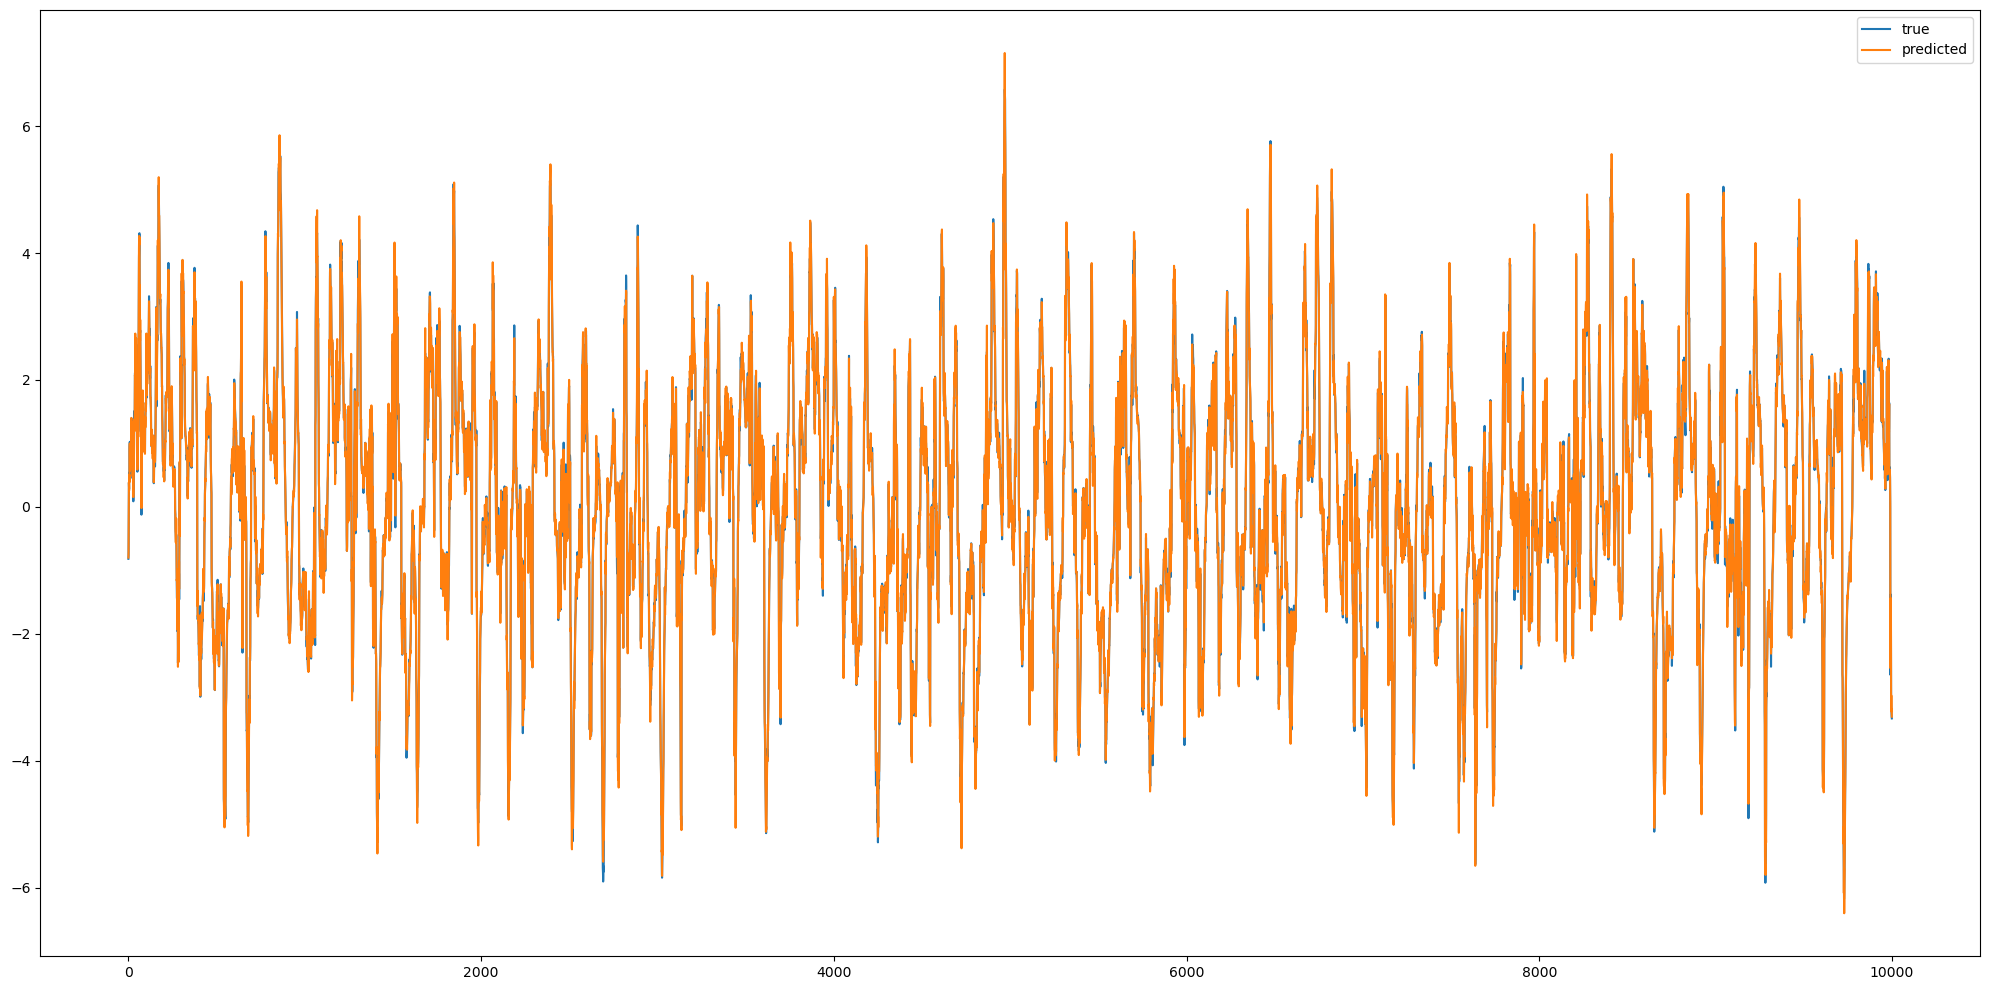

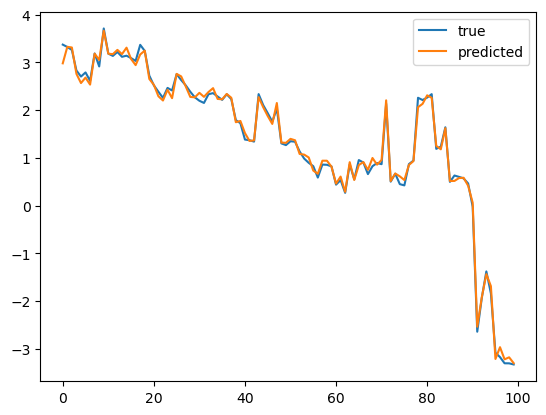

In [39]:
plt.figure(figsize=(20,10))
plt.plot(test_df['target'].to_list(),label = 'true')
plt.plot(y_pred, label = 'predicted')
plt.legend()
plt.tight_layout()
plt.show()

plt.plot(test_df['target'].to_list()[-100:],label = 'true')
plt.plot(y_pred[-100:], label = 'predicted')
plt.legend()
plt.show()



<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

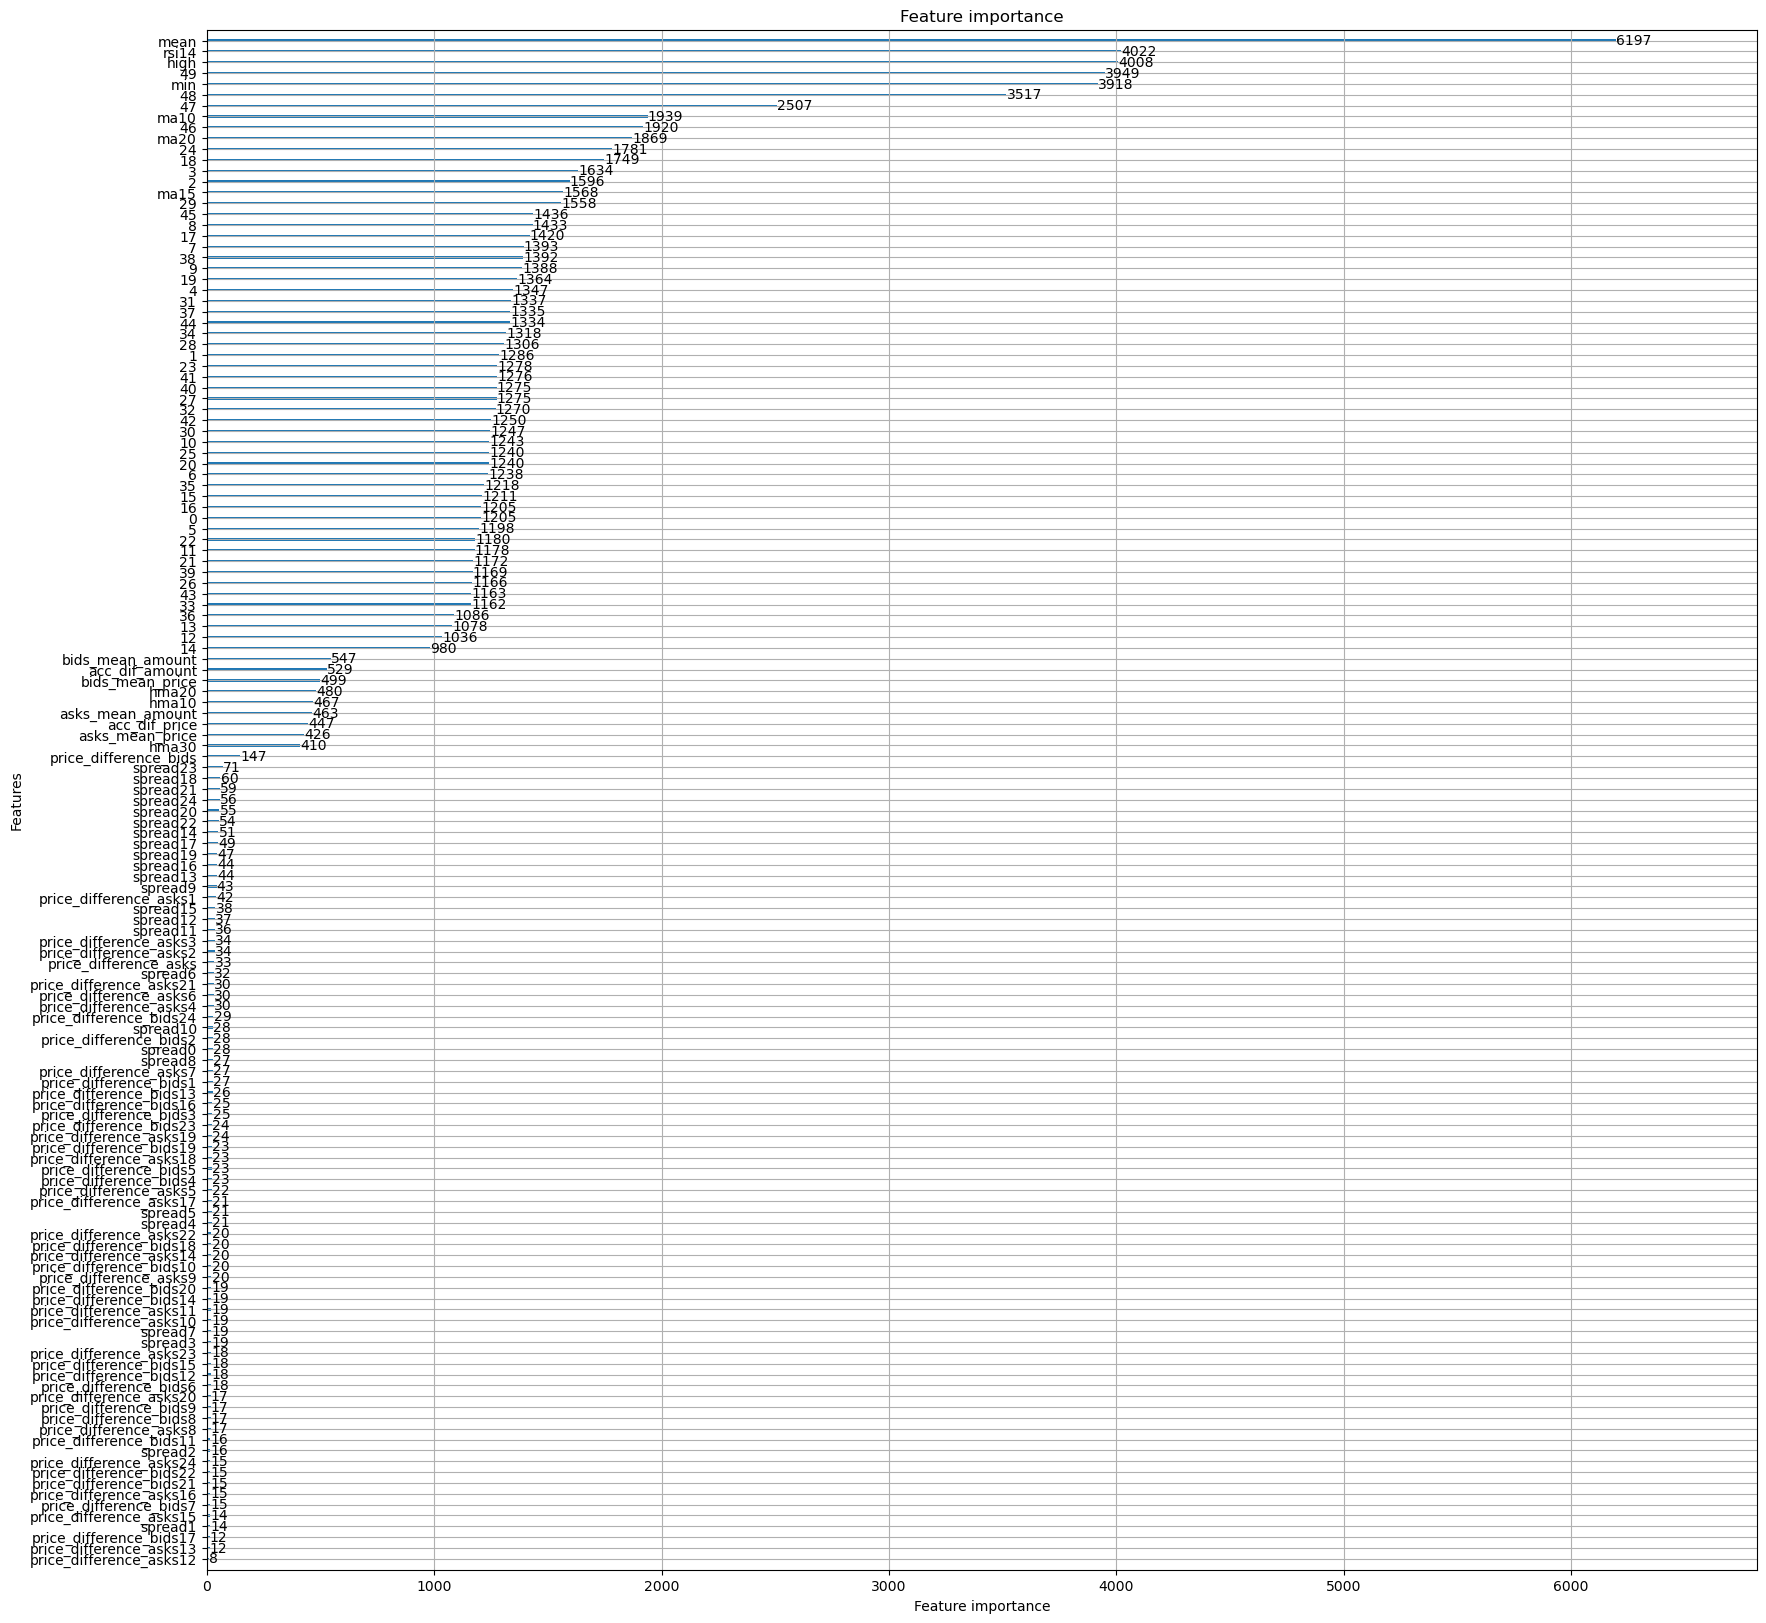

In [40]:
lgb.plot_importance(model,figsize = (20,20))

видим достаточно хороший прирост скора + видим, что индикаторные фичи достаточно часто используются моделью при очередном деление в узлах дерева.